In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.layers import SimpleRNN, Dense
from datetime import timedelta





2023-12-31 23:56:29.421703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
toks = pd.read_csv("BTC_GBP3+_hourly.csv")

In [3]:
toks.head(5)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,10/29/19 07:00,7393.60,7343.82,7356.09,13.65,100385.89,7372.48,direct,NaN
1,10/29/19 08:00,7376.57,7327.54,7372.48,39.24,289588.03,7367.00,direct,NaN
2,10/29/19 09:00,7367.00,7320.44,7367.00,61.71,454325.00,7343.10,direct,NaN
3,10/29/19 10:00,7418.84,7340.33,7343.10,23.79,175654.64,7384.95,direct,NaN
4,10/29/19 11:00,7384.95,7326.57,7384.95,24.16,177663.12,7355.92,direct,NaN


In [4]:
toks.isnull().sum()

time                    0
high                    0
low                     0
open                    0
volumefrom              0
volumeto                0
close                   0
conversionType          0
conversionSymbol    36091
dtype: int64

In [5]:
toks.drop_duplicates()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,10/29/19 07:00,7393.60,7343.82,7356.09,13.650,100385.89,7372.48,direct,NaN
1,10/29/19 08:00,7376.57,7327.54,7372.48,39.240,289588.03,7367.00,direct,NaN
2,10/29/19 09:00,7367.00,7320.44,7367.00,61.710,454325.00,7343.10,direct,NaN
3,10/29/19 10:00,7418.84,7340.33,7343.10,23.790,175654.64,7384.95,direct,NaN
4,10/29/19 11:00,7384.95,7326.57,7384.95,24.160,177663.12,7355.92,direct,NaN
...,...,...,...,...,...,...,...,...,...
36533,12/28/23 20:00,33945.92,33713.01,33880.15,30.450,1018109.69,33772.36,direct,NaN
36534,12/28/23 21:00,33885.41,33672.11,33772.36,11.630,389798.86,33755.01,direct,NaN
36535,12/28/23 22:00,33906.33,33742.62,33755.01,9.852,329583.84,33877.66,direct,NaN
36536,12/28/23 23:00,33997.74,33850.72,33877.66,8.187,274482.96,33893.81,direct,NaN


In [6]:
toks = toks.drop(columns = ['conversionType', 'conversionSymbol'])

In [7]:
toks.head()

,time,high,low,open,volumefrom,volumeto,close
0,10/29/19 07:00,7393.60,7343.82,7356.09,13.65,100385.89,7372.48
1,10/29/19 08:00,7376.57,7327.54,7372.48,39.24,289588.03,7367.00
2,10/29/19 09:00,7367.00,7320.44,7367.00,61.71,454325.00,7343.10
3,10/29/19 10:00,7418.84,7340.33,7343.10,23.79,175654.64,7384.95
4,10/29/19 11:00,7384.95,7326.57,7384.95,24.16,177663.12,7355.92


In [8]:
toks.tail()

,time,high,low,open,volumefrom,volumeto,close
36533,12/28/23 20:00,33945.92,33713.01,33880.15,30.450,1018109.69,33772.36
36534,12/28/23 21:00,33885.41,33672.11,33772.36,11.630,389798.86,33755.01
36535,12/28/23 22:00,33906.33,33742.62,33755.01,9.852,329583.84,33877.66
36536,12/28/23 23:00,33997.74,33850.72,33877.66,8.187,274482.96,33893.81
36537,12/29/23 00:00,34026.54,33721.42,33893.81,8.760,298957.16,33743.64


In [9]:
# Setting the time and date as index

toks['time'] = pd.to_datetime(toks['time'])
toks = toks.set_index('time')
toks = toks.sort_index()


In [10]:
toks

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-10-29 07:00:00,7393.60,7343.82,7356.09,13.650,100385.89,7372.48
2019-10-29 08:00:00,7376.57,7327.54,7372.48,39.240,289588.03,7367.00
2019-10-29 09:00:00,7367.00,7320.44,7367.00,61.710,454325.00,7343.10
2019-10-29 10:00:00,7418.84,7340.33,7343.10,23.790,175654.64,7384.95
2019-10-29 11:00:00,7384.95,7326.57,7384.95,24.160,177663.12,7355.92
...,...,...,...,...,...,...
2023-12-28 20:00:00,33945.92,33713.01,33880.15,30.450,1018109.69,33772.36
2023-12-28 21:00:00,33885.41,33672.11,33772.36,11.630,389798.86,33755.01
2023-12-28 22:00:00,33906.33,33742.62,33755.01,9.852,329583.84,33877.66


# Feature Engineering of Technical Indicators

**Simple Moving Average (SMA)**

In [11]:
toks['SMA_30'] = toks['close'].rolling(window=30).mean()  # 30-period SMA


**Exponential Moving Average (EMA)**

In [12]:
toks['EMA_30'] = toks['close'].ewm(span=30, adjust=False).mean()  # 30-period EMA


**Relative Strength Index (RSI)**

In [13]:
delta = toks['close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down
toks['RSI'] = 100 - (100 / (1 + rs))


**Moving Average Convergence Divergence (MACD)**

In [14]:
toks['MACD'] = toks['close'].ewm(span=12, adjust=False).mean() - toks['close'].ewm(span=26, adjust=False).mean()
toks['MACD_Signal'] = toks['MACD'].ewm(span=9, adjust=False).mean()


**Bolinder Bands (BB)**

In [15]:
SMA = toks['close'].rolling(window=20).mean()
STD = toks['close'].rolling(window=20).std()
toks['Upper_BB'] = SMA + (2 * STD)
toks['Lower_BB'] = SMA - (2 * STD)


**Volume Weighted Average Price (VWAP)**

In [16]:
cum_vol = toks['volumeto'].cumsum()
cum_vol_price = (toks['volumeto'] * (toks['high'] + toks['low'] + toks['close']) / 3).cumsum()
toks['VWAP'] = cum_vol_price / cum_vol


**Average True Range (ATR)**

In [17]:
high_low = toks['high'] - toks['low']
high_close = np.abs(toks['high'] - toks['close'].shift())
low_close = np.abs(toks['low'] - toks['close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
toks['ATR'] = true_range.rolling(window=14).mean()


**On-Balance Volume (OBV)**

In [18]:
OBV = [0]
for i in range(1, len(toks.close)):
    if toks.close[i] > toks.close[i-1]:
        OBV.append(OBV[-1] + toks.volumeto[i])
    elif toks.close[i] < toks.close[i-1]:
        OBV.append(OBV[-1] - toks.volumeto[i])
    else:
        OBV.append(OBV[-1])
toks['OBV'] = OBV


In [19]:
toks.head(5)

,high,low,open,volumefrom,volumeto,close,SMA_30,EMA_30,RSI,MACD,MACD_Signal,Upper_BB,Lower_BB,VWAP,ATR,OBV
time,,,,,,,,,,,,,,,,
2019-10-29 07:00:00,7393.60,7343.82,7356.09,13.65,100385.89,7372.48,NaN,7372.480000,NaN,0.000000,0.000000,NaN,NaN,7369.966667,NaN,0.00
2019-10-29 08:00:00,7376.57,7327.54,7372.48,39.24,289588.03,7367.00,NaN,7372.126452,0.000000,-0.437151,-0.087430,NaN,NaN,7360.365068,NaN,-289588.03
2019-10-29 09:00:00,7367.00,7320.44,7367.00,61.71,454325.00,7343.10,NaN,7370.253777,0.000000,-2.681219,-0.606188,NaN,NaN,7351.296995,NaN,-743913.03
2019-10-29 10:00:00,7418.84,7340.33,7343.10,23.79,175654.64,7384.95,NaN,7371.201921,32.144268,-1.070375,-0.699025,NaN,NaN,7356.476690,NaN,-568258.39
2019-10-29 11:00:00,7384.95,7326.57,7384.95,24.16,177663.12,7355.92,NaN,7370.215990,25.920156,-2.111904,-0.981601,NaN,NaN,7356.378283,NaN,-745921.51


In [20]:
toks.isnull().sum()

high            0
low             0
open            0
volumefrom      0
volumeto        0
close           0
SMA_30         29
EMA_30          0
RSI             1
MACD            0
MACD_Signal     0
Upper_BB       19
Lower_BB       19
VWAP            0
ATR            13
OBV             0
dtype: int64

In [21]:
toks.dropna(inplace = True)

In [22]:
toks.isnull().sum()

high           0
low            0
open           0
volumefrom     0
volumeto       0
close          0
SMA_30         0
EMA_30         0
RSI            0
MACD           0
MACD_Signal    0
Upper_BB       0
Lower_BB       0
VWAP           0
ATR            0
OBV            0
dtype: int64

In [23]:
toks.shape

(36509, 16)

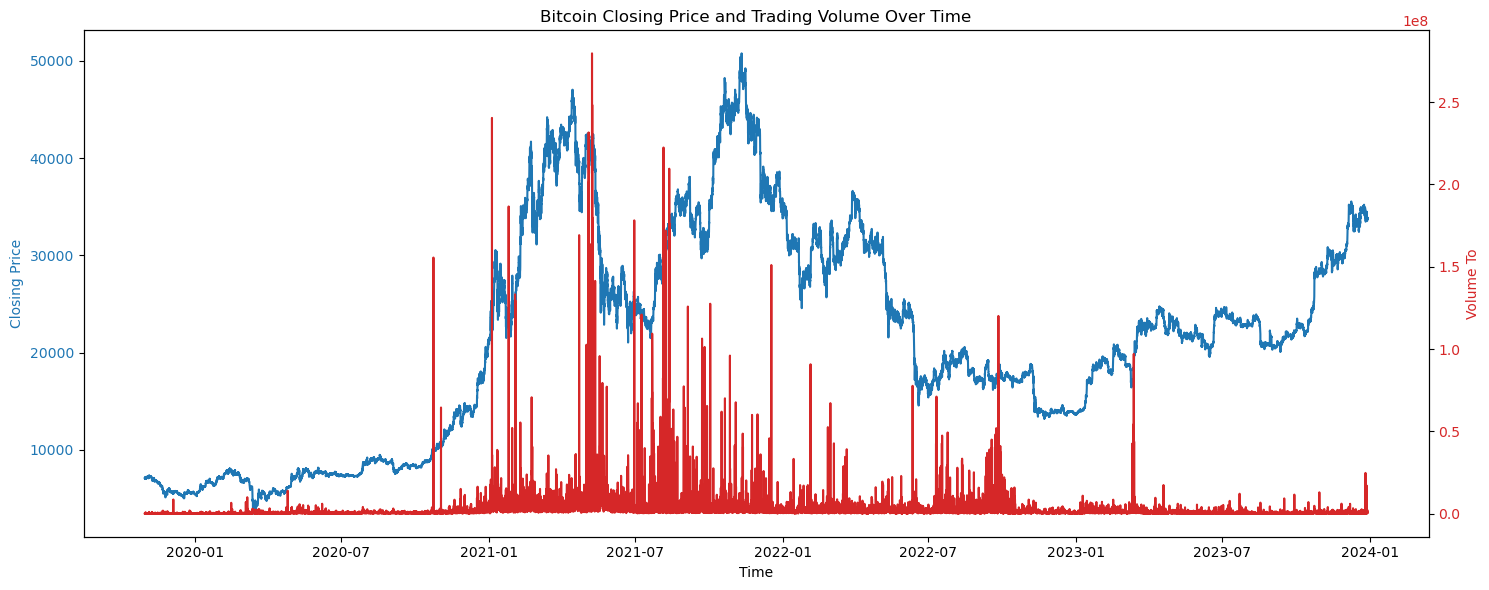

In [24]:


# Creating a time series plot for Closing Price and Volumes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plotting Closing Price
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(toks.index, toks['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for volume
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Volume To', color=color)
ax2.plot(toks.index, toks['volumeto'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Bitcoin Closing Price and Trading Volume Over Time')
fig.tight_layout()

plt.show()


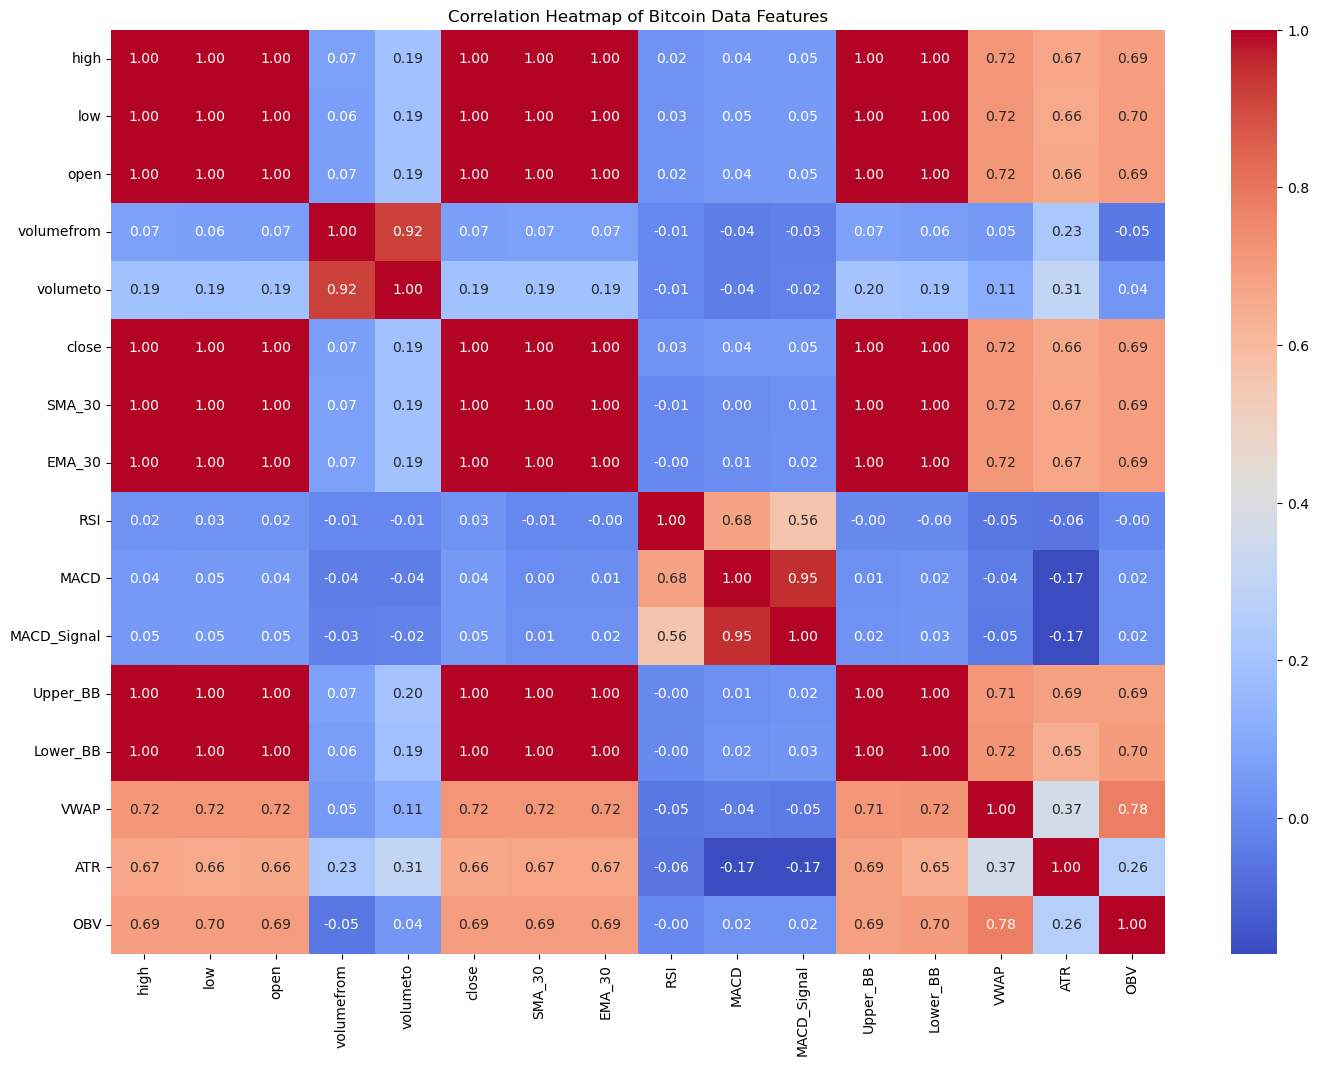

In [25]:
# Calculating the correlation matrix
corr_matrix = toks.corr()

# Setting up the matplotlib figure
plt.figure(figsize=(17, 12))

# Drawing the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Adding title
plt.title('Correlation Heatmap of Bitcoin Data Features')

# Display heatmap
plt.show()


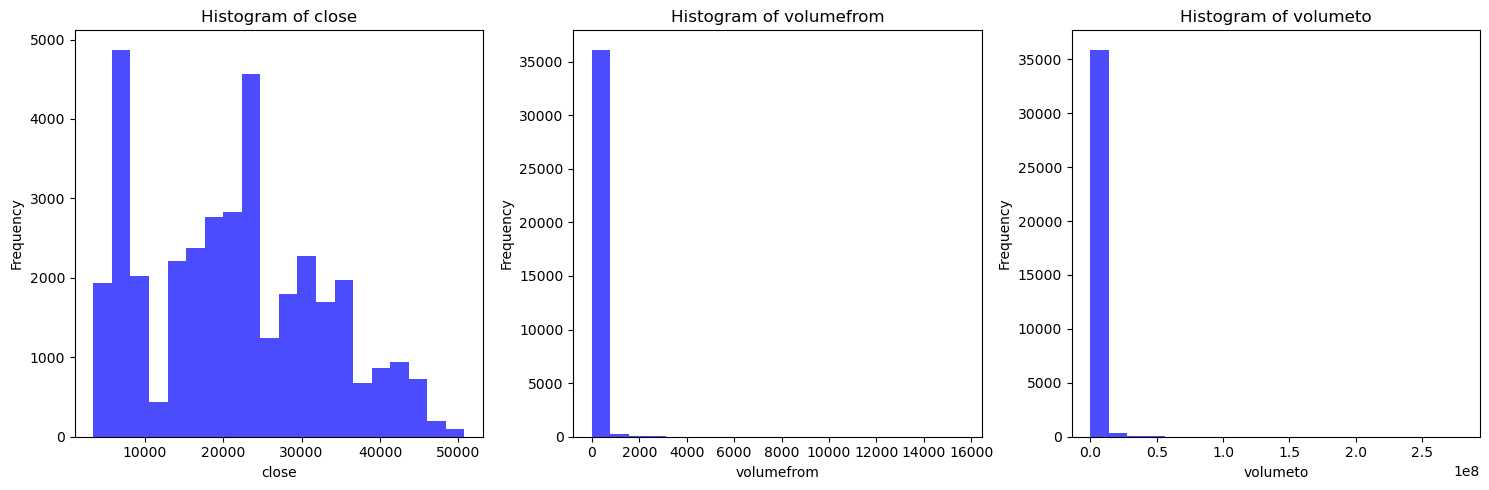

In [26]:

# Selecting a few key features for normality testing
features_to_test = ['close', 'volumefrom', 'volumeto']

# Creating histograms
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_test, 1):
    plt.subplot(1, len(features_to_test), i)
    plt.hist(toks[feature], bins=20, alpha=0.7, color='blue')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [27]:

# Shapiro-Wilk test
shapiro_results = {feature: shapiro(toks[feature].sample(min(5000, len(toks)))) 
                   for feature in features_to_test}

shapiro_results


{'close': ShapiroResult(statistic=0.9598895907402039, pvalue=4.43115796895034e-35),
 'volumefrom': ShapiroResult(statistic=0.22666287422180176, pvalue=0.0),
 'volumeto': ShapiroResult(statistic=0.24969154596328735, pvalue=0.0)}

In [28]:
features = toks.drop(columns=['close'])
target = toks['close']

print("Features shape:", features.shape)
print("Target shape:", target.shape)


Features shape: (36509, 15)
Target shape: (36509,)


In [29]:
# One scaler for the features
features_scaler = MinMaxScaler()
# Another scaler for the target
target_scaler = MinMaxScaler()


In [30]:
# Fit and transform the features
features_scaled = features_scaler.fit_transform(features)
# Fit and transform the target
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))


In [31]:


print("Scaled features shape:", features_scaled.shape)
print("Scaled target shape:", target_scaled.shape)


Scaled features shape: (36509, 15)
Scaled target shape: (36509, 1)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (29207, 15)
X_test shape: (7302, 15)
y_train shape: (29207, 1)
y_test shape: (7302, 1)


In [33]:
# Creating Sequence

def create_sequences(X, y, time_steps=48):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)

print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)


X_train_seq shape: (29159, 48, 15)
y_train_seq shape: (29159, 1)
X_test_seq shape: (7254, 48, 15)
y_test_seq shape: (7254, 1)


In [34]:

# Building the model
model = Sequential([
    SimpleRNN(50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [35]:
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
729/729 [==============================] - 3s 4ms/step - loss: 0.0013 - val_loss: 3.7902e-04
Epoch 2/20
729/729 [==============================] - 3s 4ms/step - loss: 9.4062e-05 - val_loss: 1.4605e-04
Epoch 3/20
729/729 [==============================] - 3s 4ms/step - loss: 7.0237e-05 - val_loss: 2.6836e-04
Epoch 4/20
729/729 [==============================] - 3s 4ms/step - loss: 6.6527e-05 - val_loss: 6.1499e-05
Epoch 5/20
729/729 [==============================] - 3s 4ms/step - loss: 6.4301e-05 - val_loss: 7.8113e-05
Epoch 6/20
729/729 [==============================] - 3s 4ms/step - loss: 5.8385e-05 - val_loss: 1.6025e-04
Epoch 7/20
729/729 [==============================] - 3s 4ms/step - loss: 6.0237e-05 - val_loss: 3.7353e-05
Epoch 8/20
729/729 [==============================] - 3s 4ms/step - loss: 5.3648e-05 - val_loss: 1.4557e-04
Epoch 9/20
729/729 [==============================] - 3s 4ms/step - loss: 5.2428e-05 - val_loss: 1.8782e-04
Epoch 10/20
729/729 [===========

In [36]:
# Predict on the test set
y_pred = model.predict(X_test_seq)


227/227 [==============================] - 0s 1ms/step


In [37]:
# Evaluation metrics calculation

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq, y_pred)

mape_metric = MeanAbsolutePercentageError()
mape_metric.update_state(y_test_seq, y_pred)
mape = mape_metric.result().numpy()

# Evaluation metrics

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')


Mean Absolute Error (MAE): 0.006401565398288731
Mean Squared Error (MSE): 4.932969729399502e-05
Root Mean Squared Error (RMSE): 0.007023510325613184
R-squared (R2): 0.9932854300547368
Mean Absolute Percentage Error (MAPE): 1.519684910774231


In [38]:
# Predicting the next day's closing price

latest_data = features.tail(48)  # Using the last 48 hours data
latest_data_scaled = features_scaler.transform(latest_data)
latest_data_scaled = latest_data_scaled.reshape(1, -1, latest_data_scaled.shape[1])
predicted_scaled = model.predict(latest_data_scaled)


1/1 [==============================] - 0s 12ms/step


In [39]:
# Inverse transformation of the prediction to get the actual price

predicted_price = target_scaler.inverse_transform(predicted_scaled)
print(f"Predicted closing price for the next period: {predicted_price[0][0]}")


Predicted closing price for the next period: 33458.265625


In [40]:
last_datetime = toks.index[-1]
predicted_datetime = last_datetime + timedelta(hours=48)  

print(f"Predicted closing price for {predicted_datetime}: {predicted_price[0][0]}")


Predicted closing price for 2023-12-31 00:00:00: 33458.265625
